In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# TODO

- get all player IDs

In [2]:
import pandas as pd

df = pd.read_csv('./statcast-2019-05-18.csv')
df.shape

/home/dante/venvs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(698334, 90)

In [3]:
df = df[df.game_year == 2018]
df.shape

(572572, 90)

In [4]:
player_ids = pd.read_excel('~/Downloads/SFBB-Player-ID-Map.xlsx')
player_ids.shape

(2177, 42)

In [5]:
player_ids.head()

,IDPLAYER,PLAYERNAME,BIRTHDATE,FIRSTNAME,LASTNAME,TEAM,LG,POS,IDFANGRAPHS,FANGRAPHSNAME,...,FANDUELID,DRAFTKINGSNAME,OTTONEUID,HQID,RAZZBALLNAME,FANTRAXID,FANTRAXNAME,ROTOWIRENAME,ALLPOS,NFBCLASTFIRST
0,aardsda01,David Aardsma,1981-12-27,David,Aardsma,NaN,NaN,P,1902,David Aardsma,...,NaN,David Aardsma,4362.0,NaN,David Aardsma,NaN,NaN,David Aardsma,P,"Aardsma, David"
1,abadfe01,Fernando Abad,1985-12-17,Fernando,Abad,NaN,NaN,P,4994,Fernando Abad,...,12453.0,Fernando Abad,7372.0,3556.0,Fernando Abad,01viz,"Abad, Fernando",Fernando Abad,P,"Abad, Fernando"
2,abreual01,Albert Abreu,1995-09-26,Albert,Abreu,NYY,AL,P,sa828366,Albert Abreu,...,NaN,NaN,NaN,5762.0,Albert Abreu,NaN,NaN,Albert Abreu,P,"Abreu, Albert"
3,abreubo01,Bobby Abreu,1974-03-11,Bobby,Abreu,NaN,NaN,OF,945,Bobby Abreu,...,NaN,NaN,8984.0,NaN,Bobby Abreu,NaN,NaN,NaN,OF,"Abreu, Bobby"
4,abreujo02,Jose Abreu,1987-01-29,Jose,Abreu,CHW,AL,1B,15676,Jose Abreu,...,49523.0,Jose Abreu,18286.0,4515.0,Jose Abreu,02i2e,"Abreu, Jose","Abreu, Jose",1B,"Abreu, Jose"


In [6]:
player_ids = player_ids[['MLBID', 'MLBNAME', 'TEAM', 'POS']]
batter_ids = player_ids.copy()
batter_ids.columns = [f'batter_{c.lower()}' for c in batter_ids.columns]
pitcher_ids = player_ids.copy()
pitcher_ids.columns = [f'pitcher_{c.lower()}' for c in pitcher_ids.columns]

In [7]:
df = df.merge(batter_ids, left_on='batter', right_on='batter_mlbid', how='left')
df = df.merge(pitcher_ids, left_on='pitcher', right_on='pitcher_mlbid', how='left')
df.shape

(572572, 98)

In [8]:
df[['pitcher', 'pitcher_mlbname']].drop_duplicates().isnull().sum(), \
df[['batter', 'batter_mlbname']].drop_duplicates().isnull().sum()

(pitcher              0
 pitcher_mlbname    198
 dtype: int64, batter              0
 batter_mlbname    131
 dtype: int64)

In [9]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone,batter_mlbid,batter_mlbname,batter_team,batter_pos,pitcher_mlbid,pitcher_mlbname,pitcher_team,pitcher_pos
0,94.0,5.0,LAA,-11.3601,25.1390,-31.7129,1.0,2.0,5.0,543760.0,line_drive,NaN,NaN,Marcus Semien singles on a line drive to right...,hit_into_play_score,82.497,NaN,0.213,0.207,single,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,133.98,82.73,278.0,9.0,5.0,OAK,Strategic,11.0,Bot,0.0,25.0,82.1,3.0,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9585,0.0858,Changeup,6.0,CH,598287.0,598287.0,1.0147,2.5574,Noe Ramirez,5.0,5.0,5.0,5.0,5.991,-2.6238,54.5068,5.0668,83.5,2202.0,NaN,NaN,R,2.0,180330_000927,1.3048,3.0286,NaN,NaN,X,NaN,10.1373,-121.0093,0.5756,1.0,0.9,12.0,543760.0,Marcus Semien,OAK,SS,598287.0,Noe Ramirez,LAA,P
1,94.0,5.0,LAA,-10.9769,23.0148,-32.6285,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,82.405,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,9.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,-17.0,75.1,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,-0.9663,0.0005,Changeup,5.0,CH,598287.0,598287.0,0.4161,2.7585,Noe Ramirez,5.0,5.0,5.0,5.0,6.174,-2.6167,54.3240,5.0671,82.7,2035.0,NaN,NaN,R,2.0,180330_000833,1.3010,3.0452,NaN,NaN,S,NaN,8.7471,-120.1073,1.2442,NaN,NaN,3.0,543760.0,Marcus Semien,OAK,SS,598287.0,Noe Ramirez,LAA,P
2,94.0,5.0,LAA,7.1848,23.4589,-32.9895,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,75.252,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,254.0,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,27.0,80.3,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.9971,-0.0254,Curveball,4.0,CU,598287.0,598287.0,-0.1869,2.1676,Noe Ramirez,5.0,5.0,5.0,5.0,5.360,-2.9329,55.1378,4.8254,77.2,2875.0,NaN,NaN,R,1.0,180330_000804,1.3010,3.0452,NaN,NaN,S,NaN,4.0109,-112.0582,1.4503,NaN,NaN,5.0,543760.0,Marcus Semien,OAK,SS,598287.0,Noe Ramirez,LAA,P
3,94.0,5.0,LAA,2.7950,23.1420,-33.8923,NaN,2.0,5.0,543760.0,NaN,NaN,NaN,NaN,foul,74.808,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,0.5234,-0.1545,Curveball,3.0,CU,598287.0,598287.0,0.7067,1.7718,Noe Ramirez,5.0,5.0,5.0,5.0,5.545,-2.8895,54.9534,4.8506,76.6,2722.0,NaN,NaN,R,0.0,180330_000729,1.3010,3.0452,NaN,NaN,S,NaN,6.5573,-111.0574,0.9231,NaN,NaN,9.0,543760.0,Marcus Semien,OAK,SS,598287.0,Noe Ramirez,LAA,P
4,94.0,5.0,LAA,6.9345,23.0959,-31.9858,NaN,1.0,5.0,543760.0,NaN,NaN,NaN,NaN,ball,76.087,NaN,NaN,NaN,NaN,455117.0,455117.0,527043.0,446359.0,472528.0,592743.0,457708.0,545361.0,594777.0,5.0,2018-03-29,529412.0,R,2018.0,NaN,NaN,NaN,NaN,5.0,OAK,Strategic,11.0,Bot,NaN,NaN,NaN,NaN,Strategic,459964.0,NaN,621471.0,1.0,R,1.0697,0.1136,Curveball,2.0,CU,598287.0,598287.0,2.3848,2.7632,Noe Ramirez,5.0,5.0,5.0,5.0,5.563

In [10]:
# df = df[df.type.ne('B')]
df = df[~df.game_pk.isnull()]
df.shape

(572572, 98)

# Feature engineering

In [11]:
df.events.unique()

array(['single', nan, 'triple', 'strikeout', 'field_out', 'double',
       'walk', 'grounded_into_double_play', 'home_run', 'hit_by_pitch',
       'sac_bunt', 'pickoff_caught_stealing_2b', 'caught_stealing_2b',
       'field_error', 'catcher_interf', 'force_out', 'double_play',
       'sac_fly', 'other_out', 'fielders_choice_out', 'pickoff_1b',
       'strikeout_double_play', 'fielders_choice', 'caught_stealing_3b',
       'pickoff_2b', 'triple_play', 'sac_bunt_double_play',
       'caught_stealing_home', 'sac_fly_double_play', 'pickoff_3b',
       'pickoff_caught_stealing_home', 'pickoff_caught_stealing_3b',
       'run', 'batter_interference'], dtype=object)

In [12]:
on_base_events = [
    'single',
    'double','triple'
    'home_run',
    'walk',
]
df['is_on_base_event'] = df.events.isin(on_base_events).astype(int)

In [13]:
df['runner_on_first'] = (~df.on_1b.isnull()).astype(int)
df['runner_on_second'] = (~df.on_2b.isnull()).astype(int)
df['runner_on_third'] = (~df.on_3b.isnull()).astype(int)

In [14]:
total_pitches = df.loc[:, ['game_pk', 'at_bat_number', 'pitch_number', 'pitcher']]
total_pitches['counter'] = 1

In [15]:
total_pitches.sort_values(['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'], inplace=True)
total_pitches['total_pitch_number'] = total_pitches.groupby([
    'game_pk', 'pitcher'
], as_index=False).counter.cumsum()
with pd.option_context('display.max_rows', None):
    display(total_pitches.head(100))

,game_pk,at_bat_number,pitch_number,pitcher,counter,total_pitch_number
3983,529406.0,1.0,1.0,502042.0,1,1
3970,529406.0,2.0,1.0,502042.0,1,2
3957,529406.0,2.0,2.0,502042.0,1,3
3947,529406.0,2.0,3.0,502042.0,1,4
3938,529406.0,3.0,1.0,502042.0,1,5
3919,529406.0,3.0,2.0,502042.0,1,6
3909,529406.0,3.0,3.0,502042.0,1,7
3901,529406.0,3.0,4.0,502042.0,1,8
3886,529406.0,3.0,5.0,502042.0,1,9
3872,529406.0,3.0,6.0,502042.0,1,10


In [16]:
df = df.merge(total_pitches, on=['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'])

In [17]:
numeric_features = [
    'bat_score', 'fld_score',  # these are pre-pitch
    'balls', 'strikes',
    'outs_when_up',
    'pitch_number',
    'inning',
    'total_pitch_number',
    'at_bat_number'
]

categorical_features = [
    'if_fielding_alignment',
    'of_fielding_alignment',
    'inning_topbot',  # home field advantage
    'pitch_name',
    'zone',
    'pitcher',
    'batter',
    'game_type',
    'stand',  # for batter
    'runner_on_first',
    'runner_on_second',
    'runner_on_third',
]

target = 'is_on_base_event'

In [18]:
from sklearn.base import TransformerMixin

class Encoder(TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X):
        self.mappings = {
            feature: {v: i for i, v in enumerate(X[feature].unique())}
            for feature in X.columns
        }
        return self
    
    def transform(self, X):
        return {
            f'{feature}_input': X[feature].map(self.mappings[feature]).values
            for feature in X.columns
            if feature in self.mappings
        }

    def inverse_transform(self, X, feature):
        return X.map({v: k for k, v in self.mappings[feature].items()})
    
    def get_feature_dim(self, feature):
        return len(self.mappings[feature])

In [19]:
encoder = Encoder()
X_inputs = encoder.fit_transform(df[categorical_features])
X_inputs['numeric_inputs'] = df[numeric_features].values
y = df[target].values

In [20]:
y.mean()

0.06833551064320295

# Recurrent model

In [21]:
encoder = Encoder()
encoder.fit(df)

In [22]:
numeric_features.remove('pitch_number')

In [23]:
# sample_key = df[['game_pk', 'at_bat_number']].apply(lambda x: hash(tuple(x)) % 100, axis=1)
# df_sample = df[sample_key <= 10]
df_sample = df

In [24]:
df_sample.shape

(572572, 104)

In [25]:
from tqdm import tqdm_notebook as tqdm

df_sample.sort_values(['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)

groups = df_sample.groupby([
    'game_pk', 'at_bat_number'
], as_index=False)
groups = list(groups)

X_train = []
y_train = []

def featurize_at_bat(group):
    (game_pk, at_bat_number), group_df = group
    x = encoder.transform(group_df[categorical_features])
    x['numeric_inputs'] = group_df[numeric_features].values
    y = group_df.is_on_base_event.max()
    return x, y, len(x['numeric_inputs'])

import multiprocessing as mp

pool = mp.Pool(2 * mp.cpu_count())
res = pool.imap_unordered(featurize_at_bat, tqdm(groups))
res = sorted(res, key=lambda x: x[-1])
X_train, y_train, batch_lens = zip(*res)


Process ForkPoolWorker-21:
Process ForkPoolWorker-18:
Process ForkPoolWorker-1:
Process ForkPoolWorker-5:
Process ForkPoolWorker-23:
Process ForkPoolWorker-17:
Process ForkPoolWorker-3:
Process ForkPoolWorker-7:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessin

  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py

In [26]:
len(X_train), len(y_train)

(146622, 146622)

## create the batches

In [27]:
import numpy as np

# assign each at-bat an ID so that each batch
# has roughly 32 pitches
batch_ids = np.cumsum(batch_lens) // 32
len(batch_ids), len(set(batch_ids))

(146622, 17893)

In [28]:
from itertools import groupby
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train), key=lambda x: next(i))

In [29]:
batch_id, batch = next(gb)
xs, ys = zip(*list(batch))
xs, ys

(({'if_fielding_alignment_input': array([1]),
   'of_fielding_alignment_input': array([1]),
   'inning_topbot_input': array([1]),
   'pitch_name_input': array([4]),
   'zone_input': array([10]),
   'pitcher_input': array([111]),
   'batter_input': array([238]),
   'game_type_input': array([0]),
   'stand_input': array([0]),
   'runner_on_first_input': array([1]),
   'runner_on_second_input': array([0]),
   'runner_on_third_input': array([1]),
   'numeric_inputs': array([[0., 0., 0., 0., 0., 1., 1., 1.]])},
  {'if_fielding_alignment_input': array([1]),
   'of_fielding_alignment_input': array([1]),
   'inning_topbot_input': array([1]),
   'pitch_name_input': array([4]),
   'zone_input': array([8]),
   'pitcher_input': array([111]),
   'batter_input': array([114]),
   'game_type_input': array([0]),
   'stand_input': array([1]),
   'runner_on_first_input': array([1]),
   'runner_on_second_input': array([0]),
   'runner_on_third_input': array([1]),
   'numeric_inputs': array([[ 3.,  0.,  0.

In [30]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

input_features = list(xs[0].keys())
batch_id, batch = next(gb)
xs, ys = zip(*list(batch))

X_batch = {}

for f in input_features:
    X_batch[f] = pad_sequences([x[f] for x in xs])
y_batch = np.array(ys)

X_batch, y_batch

Using TensorFlow backend.


({'if_fielding_alignment_input': array([[1],
         [1],
         [1],
         [2],
         [0],
         [1],
         [2],
         [1],
         [1],
         [0],
         [2],
         [1],
         [0],
         [0],
         [1],
         [2],
         [1],
         [2],
         [2],
         [1],
         [1],
         [1],
         [2],
         [1],
         [1],
         [1],
         [2],
         [1],
         [1],
         [1],
         [1],
         [1]], dtype=int32), 'of_fielding_alignment_input': array([[1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [0],
         [1],
         [1],
         [2],
         [1],
         [2],
         [1],
         [1],
         [1],
         [1],
         [0],
         [1],
         [1],
         [0],
         [0],
         [1],
         [1],
         [1],
         [1],
         [1]], dtype=int32), 'inning_topbot

In [31]:
X_batch['numeric_inputs'].shape, X_batch['batter_input'].shape, y_batch.shape

((32, 1, 8), (32, 1), (32,))

In [32]:
def batch_generator(gb):
    for batch_id, batch in gb:
        xs, ys = zip(*list(batch))
        X_batch = {}
        for f in input_features:
            X_batch[f] = pad_sequences([x[f] for x in xs])
        yield X_batch, np.array(ys)
        

In [33]:
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train), key=lambda x: next(i))
batches = list(batch_generator(gb))

In [34]:
len(batches)

17893

In [35]:
batches[0][0]['numeric_inputs'].shape, batches[0][1].shape

((31, 1, 8), (31,))

## build model

In [57]:
import keras
import keras.backend as K

categorical_dimmensions = {
    'batter': 2,
    'pitcher': 4,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = []
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings.append(embedding)
X_embeddings = keras.layers.Concatenate(axis=-1)(embeddings)

X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.Dense(32)(X)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1)(X)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Dense(1, activation='sigmoid')(X)

model = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=X)

In [58]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [59]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [60]:
# 0.4790
def g():
    while True:
        np.random.shuffle(batches)
        for X, y in batches:
            yield X, y
model.fit_generator(g(), steps_per_epoch=len(batches), epochs=10)

Epoch 1/25
17893/17893 [==============================] - 157s 9ms/step - loss: 0.5366
Epoch 2/25
17893/17893 [==============================] - 155s 9ms/step - loss: 0.5110
Epoch 3/25
17893/17893 [==============================] - 155s 9ms/step - loss: 0.5049
Epoch 4/25
17893/17893 [==============================] - 155s 9ms/step - loss: 0.5009
Epoch 5/25
17893/17893 [==============================] - 156s 9ms/step - loss: 0.4981
Epoch 6/25
  228/17893 [..............................] - ETA: 2:35 - loss: 0.4940

KeyboardInterrupt: 

## p/r curve just for kicks

In [61]:
preds = np.concatenate([model.predict(x) for x, _ in batches])
y_all = np.concatenate([y for _, y in batches])

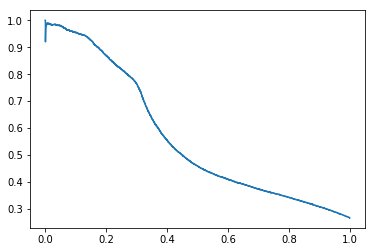

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
%matplotlib inline
p, r, t = precision_recall_curve(y_all, preds)
plt.plot(r, p)

## look at batters

In [63]:
def get_feature_embeddings(X, feature, model):
    input_ = encoder.transform(X)[f'{feature}_input']
    return get_embeddings(input_, model, feature)

def get_embeddings(X, model, feature):
    input_ = model.get_layer(f'{feature}_input').get_output_at(-1)
    encoding = model.get_layer(f'{feature}_embedding').get_output_at(-1)
    return keras.models.Model(inputs=input_, outputs=encoding).predict(X)

In [64]:
batters = df[['batter', 'batter_mlbname', 'batter_team', 'batter_pos']].drop_duplicates()
batter_embeddings = get_feature_embeddings(batters, 'batter', model)
x, y = zip(*batter_embeddings.reshape((-1, 2)))

In [65]:
batter_embeddings.shape

(951, 1, 2)

In [66]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()

lookat = {
    'Mike Trout': 'red',
    'Christian Yelich': 'green',
    'Bryce Harper': 'orange',
    'Mookie Betts': 'pink',
    'Rhys Hoskins': 'purple',
    'Jean Segura': 'grey'
}

batters['sort_key'] = batters.batter_mlbname.isin(lookat)
batters.sort_values('sort_key', inplace=True)

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            desc=batters.batter_mlbname
#             desc=batters.apply(lambda x: str((x.batter_mlbname, x.batter_pos)), axis=1)
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)


Loading BokehJS ...

## look at pitchers

In [67]:
from sklearn.manifold import TSNE
pitchers = df[['pitcher', 'pitcher_mlbname']].drop_duplicates()
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher', model)
x, y = zip(*TSNE(2).fit_transform(pitcher_embeddings.reshape((-1, 4))))

In [68]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat = {
    'Noah Syndergaard': 'red',
    'Clayton Kershaw': 'green',
    'Aaron Nola': 'orange',
    'Craig Kimbrel': 'pink'
}

pitchers['sort_key'] = pitchers.pitcher_mlbname.isin(lookat)
pitchers.sort_values('sort_key', inplace=True)

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            desc=pitchers.pitcher_mlbname
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)

Loading BokehJS ...